In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 100)

In [3]:
df = pd.read_csv('~/Desktop/maven_wave/Baker - Lending Club Data - DR_Demo_Lending_Club.csv',
                 index_col='Id',
                 parse_dates=['earliest_cr_line'],
                 dtype={'is_bad': bool})
df.sample()

,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,zip_code,addr_state,debt_to_income,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
5840,False,boulder station hotel casino,3,RENT,30000.0,not verified,n,Loan is to help pay off bills and go to real estate investing school.,educational,Pay off Bills and Education,891xx,NV,12.76,0.0,1999-01-01,1.0,0.0,0.0,6.0,0.0,5830,64.1,8.0,f,0.0,1,PC3


In [8]:
# Some featurization/data cleanup
df.loc[df.earliest_cr_line >= pd.to_datetime('2020-01-01'), 'earliest_cr_line'] = pd.NaT
df['earliest_cr_cohort'] = df.earliest_cr_line.dt.strftime('%Y')
df['pymnt_plan'] = df.pymnt_plan.map({'y': True, 'n': False})

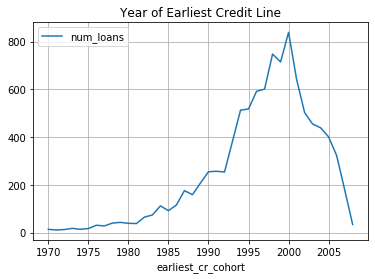

In [9]:
df.groupby('earliest_cr_cohort').size().plot(grid=True, label='num_loans')
plt.legend()
plt.title('Year of Earliest Credit Line');

In [10]:
df.isna().sum().sort_values(ascending=False)

pymnt_plan                     10000
mths_since_last_record          9160
mths_since_last_delinq          6316
Notes                           3230
emp_title                        592
earliest_cr_cohort                40
earliest_cr_line                  40
collections_12_mths_ex_med        32
revol_util                        26
inq_last_6mths                     5
delinq_2yrs                        5
open_acc                           5
pub_rec                            5
total_acc                          5
purpose                            4
annual_inc                         1
initial_list_status                0
mths_since_last_major_derog        0
emp_length                         0
home_ownership                     0
verification_status                0
purpose_cat                        0
zip_code                           0
addr_state                         0
debt_to_income                     0
policy_code                        0
revol_bal                          0
i

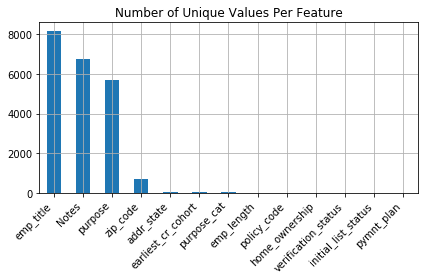

In [11]:
df.select_dtypes(include='object').nunique().sort_values(ascending=False).plot(kind='bar', grid=True)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Unique Values Per Feature')
plt.xticks(rotation=45, ha='right')
plt.gcf().tight_layout()

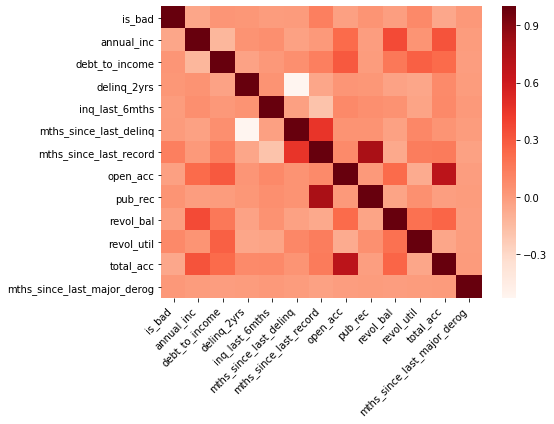

In [12]:
plt.figure(figsize=(8, 6))
corr = df.select_dtypes(include=[np.number, bool]).drop(columns=['collections_12_mths_ex_med']).corr()
sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
plt.xticks(rotation=45, ha='right')
plt.gcf().tight_layout()

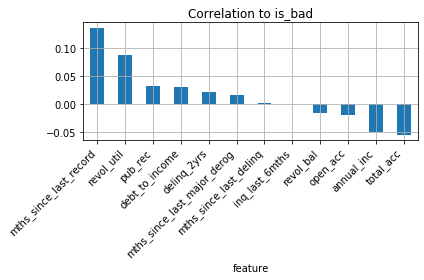

In [16]:
corr_2 = corr.unstack().to_frame('value').reset_index()
corr_2 = corr_2[corr_2.level_0 != corr_2.level_1]

tmp = corr_2[corr_2.level_0 == 'is_bad'].rename(columns={'level_1': 'feature'}).set_index('feature')[
    ['value']].sort_values('value', ascending=False)
tmp.plot(kind='bar', grid=True, legend=None)
plt.title('Correlation to is_bad')
plt.xticks(rotation='45', ha='right')
plt.gcf().tight_layout()

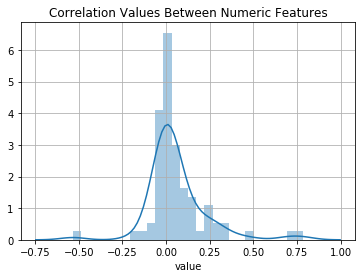

In [17]:
corr_2['features_set'] = corr_2.apply(lambda row: str(sorted([row.level_0, row.level_1])), axis=1)
corr_2 = corr_2.drop_duplicates(subset=['features_set']) \
    .drop(columns=['level_0', 'level_1']) \
    .sort_values('value', ascending=False).dropna()
sns.distplot(corr_2.value)
plt.title('Correlation Values Between Numeric Features')
plt.grid();

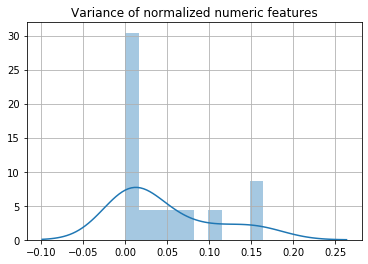

In [19]:
scaler = preprocessing.MinMaxScaler()
df_scale = pd.DataFrame(index=df.select_dtypes(include=[np.number, bool]).index,
                        data=scaler.fit_transform(df.select_dtypes(include=[np.number, bool])),
                        columns=df.select_dtypes(include=[np.number, bool]).columns)
sns.distplot(df_scale.var(), bins=10)
plt.title('Variance of normalized numeric features')
plt.grid()